In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.set_figure_params(dpi=200, figsize=(4, 4), frameon=False)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
%load_ext autoreload
%autoreload 2

### Download Dataset and split into reference dataset and query dataset

In [5]:
adata = sc.read('./pbmc_vars_sb.h5ad')

In [6]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [7]:
adata.X = adata.layers["counts"].copy()

In [8]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [9]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [10]:
sc.pp.normalize_total(adata)

In [11]:
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [13]:
select_terms = adata.varm['I'].sum(0)>12

In [14]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [15]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [16]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [17]:
adata.X = adata.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [18]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False,)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 4


In [19]:
ALPHA = 0.7

In [22]:
EPOCHS = 400

In [23]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [24]:

intr_cvae.train(
    n_epochs=EPOCHS, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=None,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |██████--------------| 31.5%  - epoch_loss:  875.84 - epoch_recon_loss:  848.46 - epoch_kl_loss:   54.76 - val_loss:  934.62 - val_recon_loss:  906.49 - val_kl_loss:   56.26
ADJUSTED LR
 |███████-------------| 37.8%  - epoch_loss:  872.27 - epoch_recon_loss:  845.02 - epoch_kl_loss:   54.51 - val_loss:  936.71 - val_recon_loss:  908.71 - val_kl_loss:   56.00
ADJUSTED LR
 |████████------------| 41.0%  - epoch_loss:  876.04 - epoch_recon_loss:  848.71 - epoch_kl_loss:   54.66 - val_loss:  936.79 - val_recon_loss:  908.87 - val_kl_loss:   55.84
ADJUSTED LR
 |█████████-----------| 47.8%  - epoch_loss:  873.20 - epoch_recon_loss:  845.87 - epoch_kl_loss:   54.67 - val_loss:  939.41 - val_recon_loss:  911.43 - val_kl_loss:   55.96
ADJUSTED LR
 |██████████----------| 51.5%  - epoch_loss:  873.55 - epoch_recon_loss:  846.23 - epoch_kl_loss:   54.64 - val_loss:  935.04 - val_recon_loss:  907.11 - val_kl_loss:   55.86
ADJUSTED LR
 |██████████----------| 54.8%  - epoch_loss:  877.50 - epoch_reco

In [26]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [27]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['PRE_NOTCH_TRANSCRIPTION_AND_TR',
 'DOWNREGULATION_OF_SMAD2_3_SMAD',
 'REGULATION_OF_ORNITHINE_DECARB',
 'CA_DEPENDENT_EVENTS',
 'INTEGRIN_ALPHAIIB_BETA3_SIGNAL',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'GLUCAGON_SIGNALING_IN_METABOLI',
 'CLASS_B_2_SECRETIN_FAMILY_RECE',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'G_BETA_GAMMA_SIGNALLING_THROUG',
 'CTLA4_INHIBITORY_SIGNALING',
 'SMOOTH_MUSCLE_CONTRACTION',
 'ACTIVATION_OF_NMDA_RECEPTOR_UP',
 'POST_NMDA_RECEPTOR_ACTIVATION_',
 'DEPOSITION_OF_NEW_CENPA_CONTAI',
 'RECYCLING_PATHWAY_OF_L1',
 'ION_TRANSPORT_BY_P_TYPE_ATPASE',
 'ION_CHANNEL_TRANSPORT',
 'MEIOTIC_RECOMBINATION',
 'PLATELET_AGGREGATION_PLUG_FORM',
 'LIPID_DIGESTION_MOBILIZATION_A',
 'PACKAGING_OF_TELOMERE_ENDS',
 'G2_M_CHECKPOINTS']

In [28]:
MEAN = False

In [29]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [30]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [31]:
sc.tl.umap(adata)

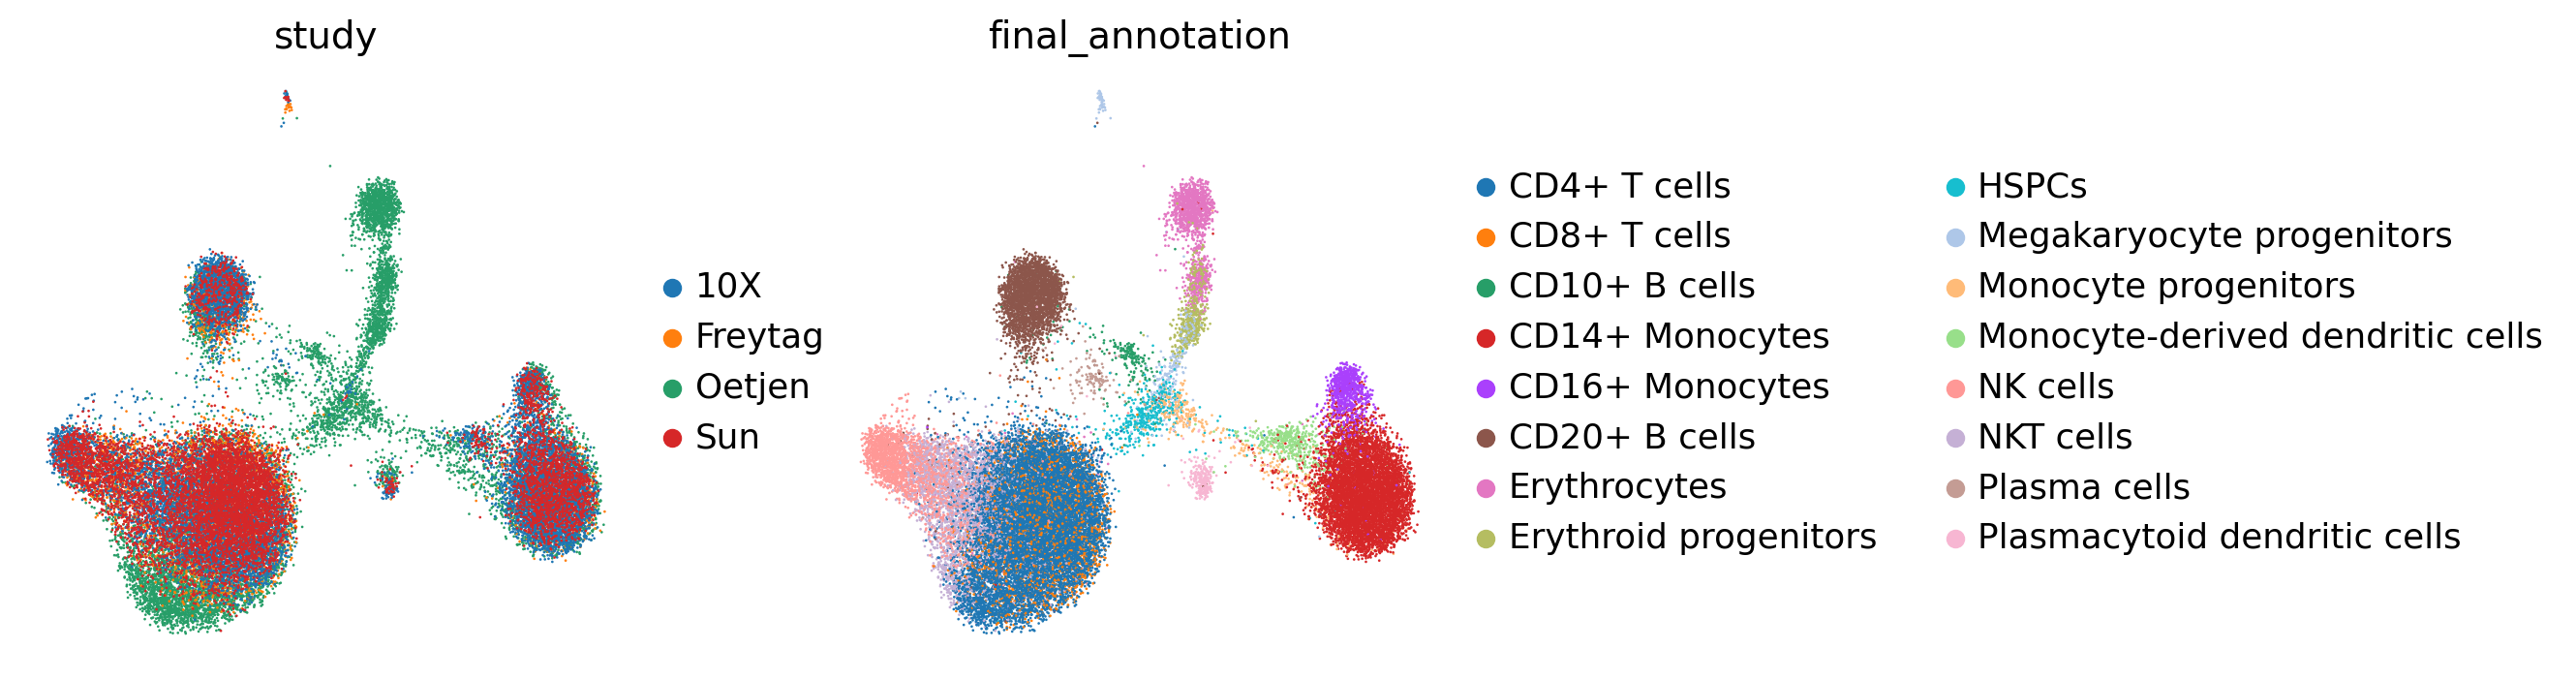

In [32]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [33]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [34]:
kang = sc.read('./kang_count.h5ad')[:, adata.var_names].copy()

In [35]:
kang.obs['study'] = 'Kang'

In [36]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [37]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 5


In [39]:
q_intr_cvae.train(n_epochs=100, alpha_epoch_anneal=10, weight_decay=0.0, alpha_kl=0.1, seed=2020, use_early_stopping=True)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |████████████████████| 100.0%  - epoch_loss:  521.98 - epoch_recon_loss:  514.52 - epoch_kl_loss:   74.62 - val_loss:  527.47 - val_recon_loss:  520.01 - val_kl_loss:   74.63
Saving best state of network...
Best State was in Epoch 94


In [40]:
#q_intr_cvae.save('q_intr_cvae_nb_alpha_kl_0_001_sd_2021')

In [41]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [42]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [43]:
sc.tl.umap(kang)

... storing 'study' as categorical


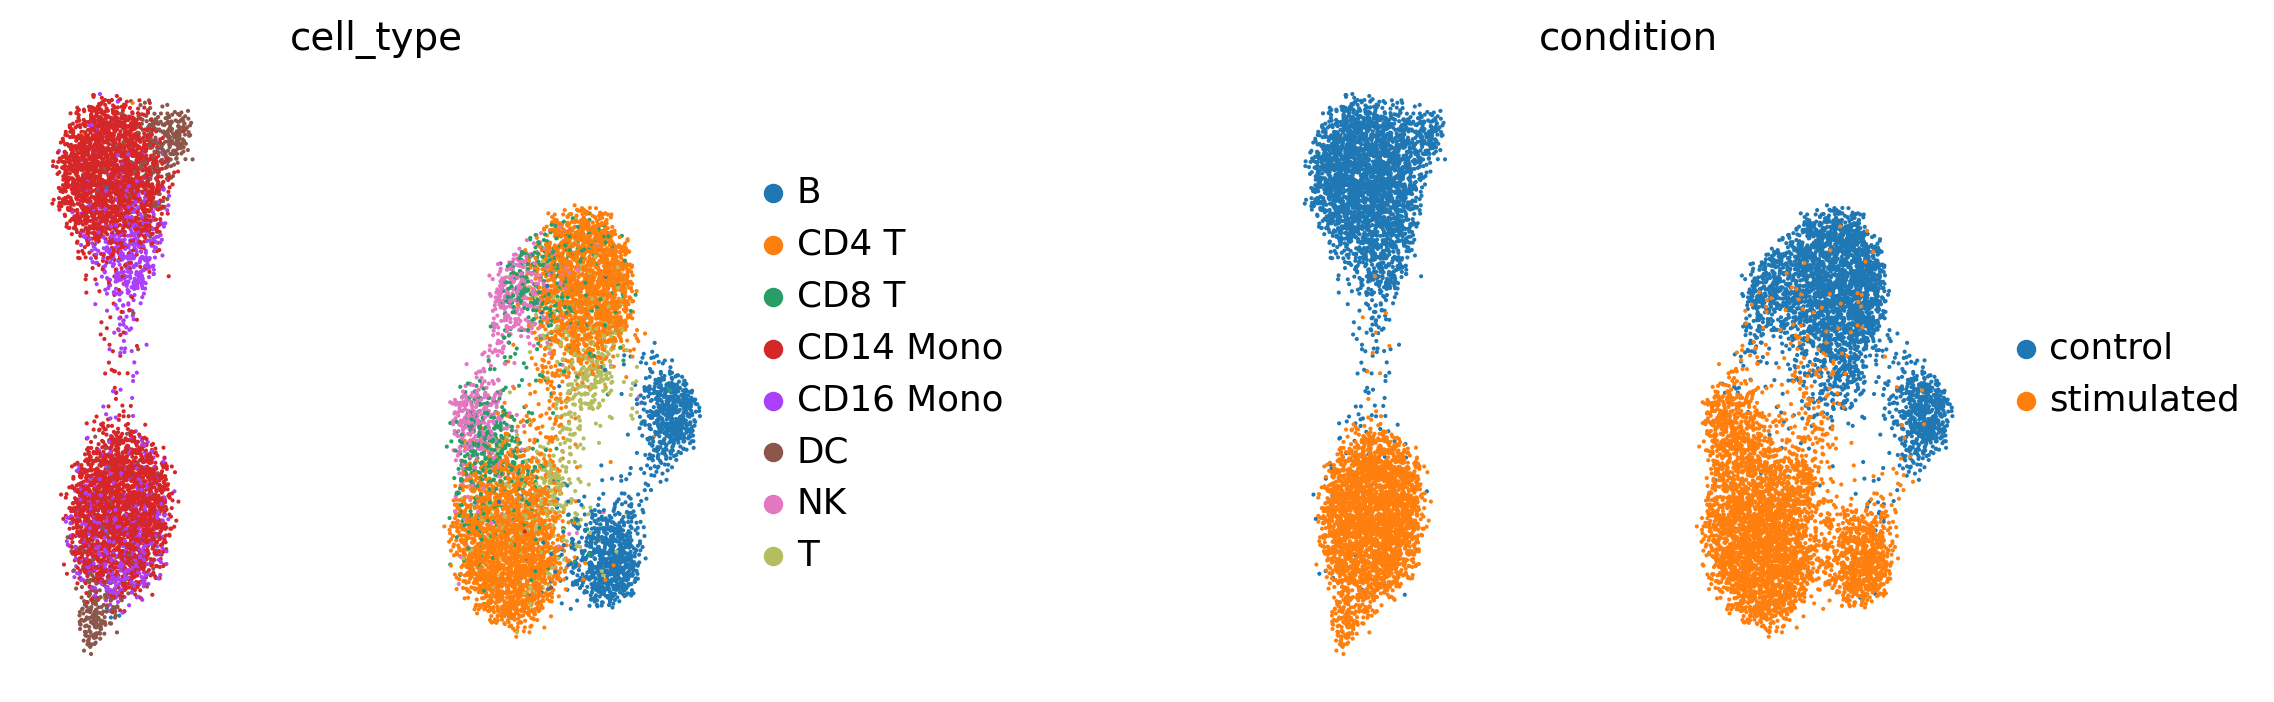

In [44]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

In [45]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [46]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [47]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [48]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [49]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [50]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [51]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [52]:
categories

array(['B', 'CD10+ B cells', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD20+ B cells', 'CD4 T', 'CD4+ T cells',
       'CD8 T', 'CD8+ T cells', 'DC', 'Erythrocytes',
       'Erythroid progenitors', 'HSPCs', 'Megakaryocyte progenitors',
       'Monocyte progenitors', 'Monocyte-derived dendritic cells', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [53]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [54]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

In [55]:
sc.pp.neighbors(kang_pbmc)

         Falling back to preprocessing with `sc.pp.pca` and default params.


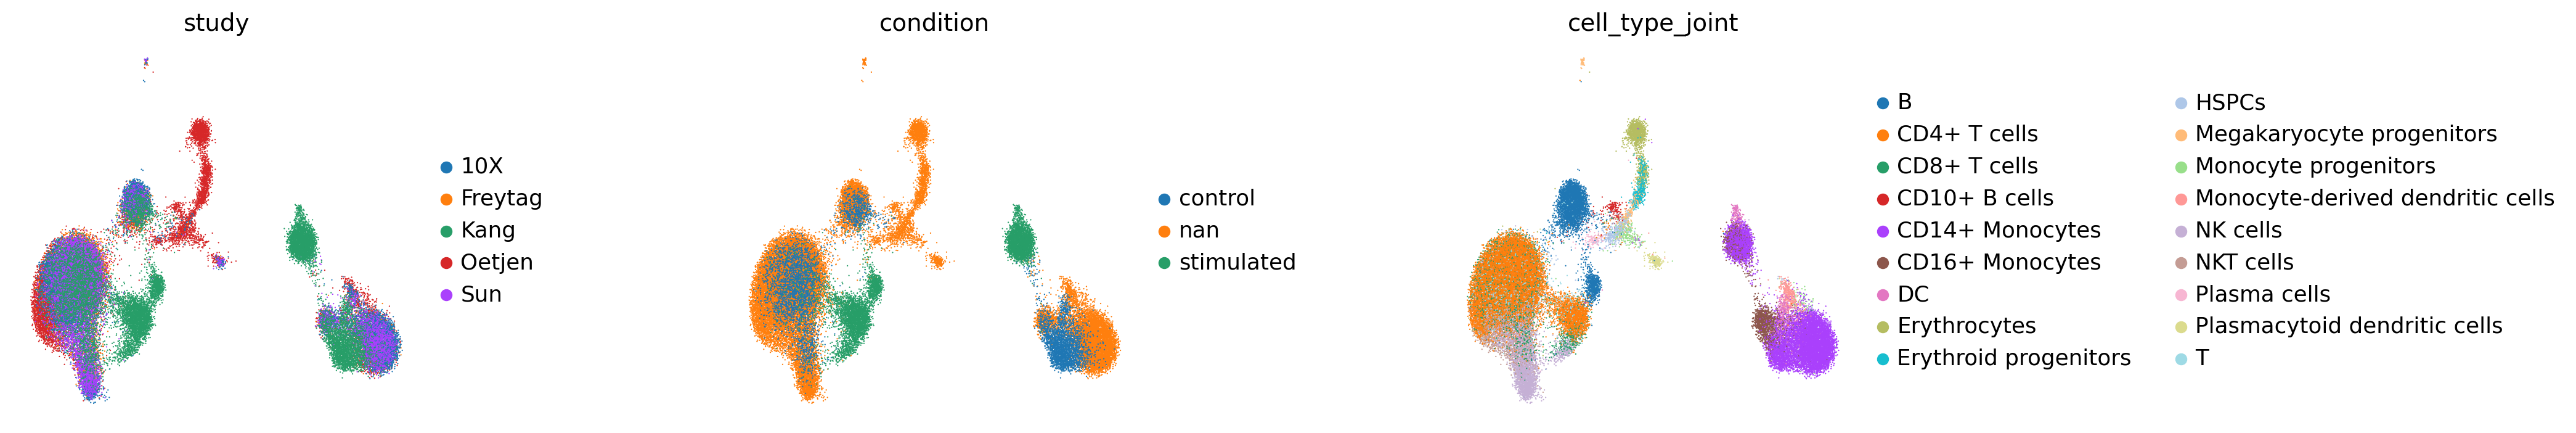

In [60]:
sc.pl.umap(kang_pbmc, color=['study',"condition", 'cell_type_joint'], frameon=False, wspace=0.6)

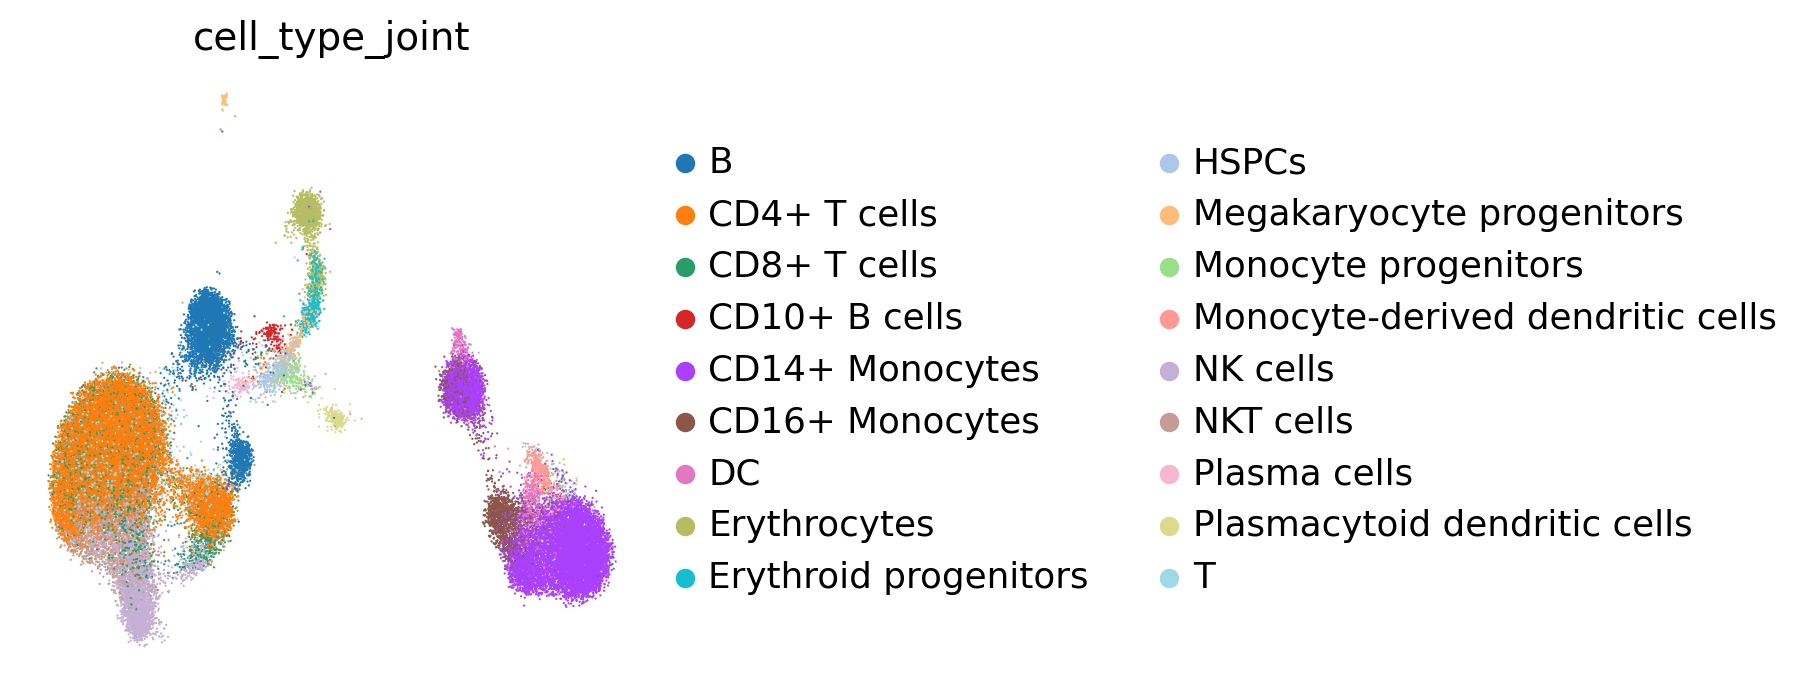

In [57]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

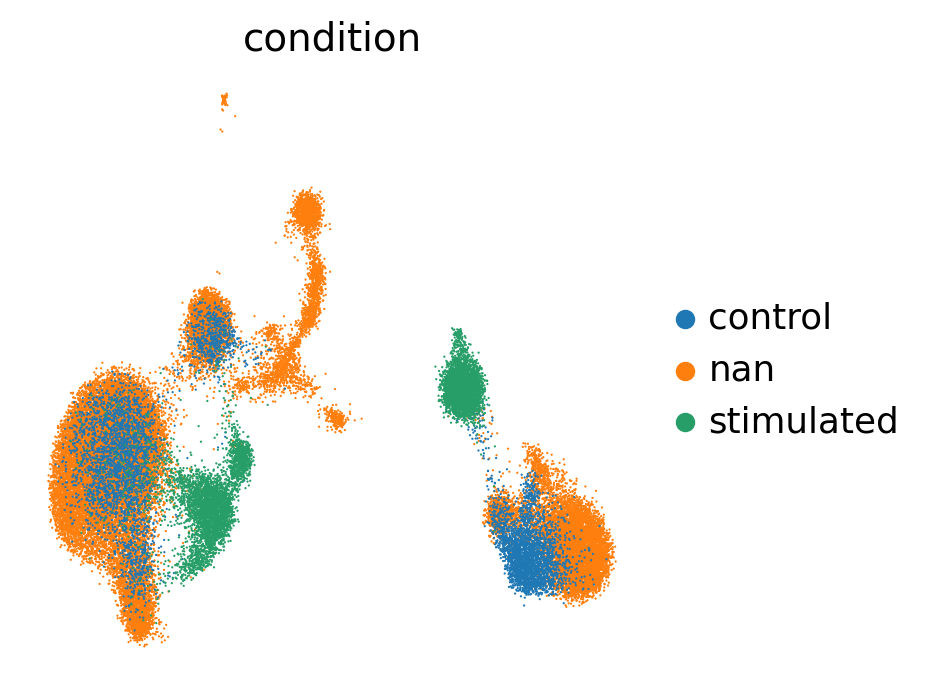

In [58]:
sc.pl.umap(kang_pbmc, color='condition', frameon=False, wspace=0.6)

In [ ]:
#kang_pbmc.write('kang_pbmc_integrated.h5ad')